# Simple MLP in PyTorch

In this notebook we will detail how to create and train a multilayer perceptron using pytorch. We will go through:
 
1. Two different ways of creating an MLP
2. Create a standard training loop
3. Visualize results

In [1]:
import torch #should be installed by default in any colab notebook
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

plt.rcParams["figure.figsize"] = (20,10)

In [2]:
# If this cell fails you need to change the runtime of your colab notebook to GPU
# Go to Runtime -> Change Runtime Type and select GPU
assert torch.cuda.is_available(), "GPU is not enabled"

# use gpu if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Data

Before training we need data! So lets create an artificial dataset for our model to learn. This is just a setup section, so you can skip it and move on to the model definition if you want.


In [3]:
#@title The code in this cell defines a function to generate training and validation data. Just hit the play button before continuing
def generate_data(n_samples, generator, regression=False, noise_scale=2, **kwargs):

    x_train, y_train = generator(n_samples, **kwargs) # training data

    if "noise" in kwargs:
        kwargs["noise"] *= noise_scale
    
    x_val, y_val = generator(n_samples, **kwargs)

    # Plot the data
    fig, ax = plt.subplots(1, 2)
    ax[0].set_title("Training Data") 
    ax[1].set_title("Validation Data")

    if regression:
        ax[0].scatter(x_train, y_train, cmap=plt.cm.coolwarm)
        ax[1].scatter(x_val, y_val, cmap=plt.cm.coolwarm)
    else:
        ax[0].scatter(x_train[:, 0], x_train[:, 1], c=y_train, cmap=plt.cm.coolwarm)
        ax[1].scatter(x_val[:, 0], x_val[:, 1], c=y_val, cmap=plt.cm.coolwarm)

    return x_train, y_train, x_val, y_val

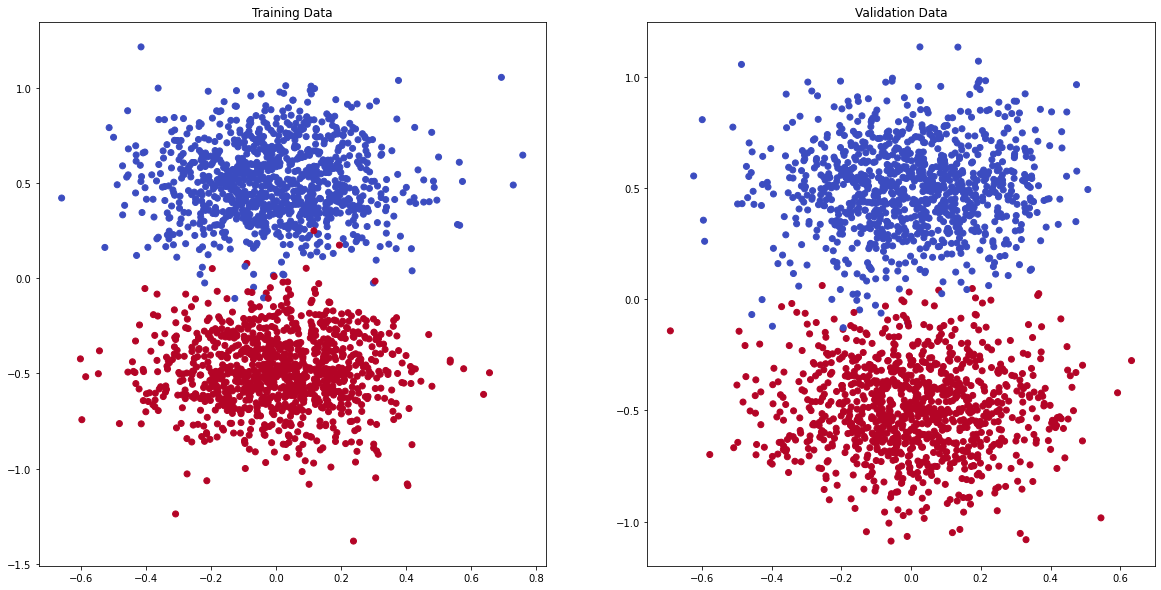

In [12]:
# find more datasets at https://scikit-learn.org/stable/modules/classes.html#samples-generator
from sklearn.datasets import make_blobs, make_circles
plt.rcParams["figure.figsize"] = (20,10)

N = 1000 # number of sample
xBlobsTrain, yBlobsTrain, xBlobsVal, yBlobsVal = generate_data([N, N], make_blobs, centers=[[0, 0.5], [0, -0.5]], cluster_std=0.2)

#Convert the data from numpy arrays into PyTorch tensors
xBlobsTrain = torch.from_numpy(xBlobsTrain).float()
yBlobsTrain = torch.from_numpy(yBlobsTrain).long()
xBlobsVal = torch.from_numpy(xBlobsVal).float()
yBlobsVal = torch.from_numpy(yBlobsVal).long()

# move data to gpu if available
xBlobsTrain = xBlobsTrain.to(device)
yBlobsTrain = yBlobsTrain.to(device)

xBlobsVal = xBlobsVal.to(device)
yBlobsVal = yBlobsVal.to(device)

In [52]:
#@title The code in this cell is just for visualization no need to worry about it. Just hit the play button before continuing { display-mode: "form" }
# Dont worry about the code in this cell it is just for visualization purposes you dont need to understand or edit it yet

def plot_model(x, y, model, axis):

    mesh = torch.arange(-2, 2, 0.01)

    xx, yy = torch.meshgrid(mesh, mesh)
    with torch.no_grad():
        data = torch.from_numpy(np.vstack((xx.reshape(-1), yy.reshape(-1))).T).float()
        Z = model(data.cuda().detach())
    Z = Z.max(1)[1].reshape(xx.shape)
    axis.contourf(xx, yy, Z.cpu(), cmap=plt.cm.coolwarm, alpha=0.3)
    axis.scatter(x[:, 0].cpu(), x[:, 1].cpu(), c=y.cpu(), s=20, cmap=plt.cm.coolwarm)
    axis.get_xaxis().set_ticks([])
    axis.get_yaxis().set_ticks([])


def plot_regressor(x, y, model, axis):
    
    with torch.no_grad():
        y_pred = model(x)
    axis.scatter(x.cpu(), y.cpu())
    axis.plot(x.cpu(), y_pred.cpu(), 'r-', lw=5, label="Model Prediction")
    axis.get_xaxis().set_ticks([])
    axis.get_yaxis().set_ticks([])

def draw_plots(x, y, model, losses, visualize_surface = False, visualize_regressor = False):

    if visualize_surface and visualize_regressor:
        raise ValueError("Expected only one of 'visualize_error' or 'visualize_regressor' to be True.")

    if visualize_surface:
        fig, ax = plt.subplots(1, 2)
        ax[0].set_title("Output Space")
        ax[1].set_title("Losses")
        ax[1].plot(losses["train"], label="training loss")
        ax[1].plot(losses["val"], label="validation loss")
        ax[1].set_xlabel("Epoch")
        plot_model(x, y, model, ax[0])
    
    elif visualize_regressor:
        fig, ax = plt.subplots(1, 2)
        ax[0].set_title("Validation Data")
        ax[1].set_title("Losses")
        ax[1].plot(losses["train"], label="training loss")
        ax[1].plot(losses["val"], label="validation loss")
        ax[1].set_xlabel("Epoch")
        plot_regressor(x, y, model, ax[0])

    else:
        plt.plot(losses["train"], label="training loss")
        plt.plot(losses["val"], label="validation loss")
    
    plt.legend()
    plt.pause(0.000001)
    plt.show()   

# The Model

Now that these basic concepts are out of the way and we have our data lets take a look at how to create a simple MLP in PyTorch

The ```torch.nn``` [package](https://pytorch.org/docs/stable/nn.html) is the one containing all of the neural network related layers, operations etc.

In order to create a simple MLP we can define a sequential module like so:



```
import torch.nn as nn

model = nn.Sequential(nn.Linear(inp_dim, hidden_dim),
                      nn.ReLU(),
                      nn.Linear(hidden_dim, output_dim))
```

So now we can feed data into this model and the ```nn``` module will take care of the forward pass.

Some more complicated acrchitectures will require you to detail the forward pass of the model. This will require creating a class that inherits from ```nn.Module``` and define its ```forward``` and ```__init__``` methods.

```
import torch.nn as nn

class SimpleMLP(nn.Module):

    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(inp_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    
    def forward(self, x):
        out = self.fc1(x)
        out = torch.relu(out)
        return self.fc2(out)
```

Notice how this approach allows more flexibility since we can insert ANY python statement in the forward method, such as ```print```, ```if else```, etc.

Since our model for this first session is very simple we will use the first approach in this notebook, but we encourage you to try your own model using the second approach.




## Linear Model

We will start by defining a very simple, linear model. This is a very inefficient model, but it serves us in order to have a template to build on afterwards.

The input of this model will be set to 2 (we have two features in our datasets) and the output to 2 (we will predict one of two classes).

The output of the model will be a raw, unnormalized score for each class. The scores (the logits) that will then go through softmax plus cross entropy loss to compare against the true labels.

In [53]:
import torch.nn as nn # nn package to create our linear model

D = 2  # input dimensions
C = 2  # num_classes
H = 100  # num_hidden_units

# each Linear module has a weight and bias
modelMLP = nn.Sequential(
    nn.Linear(D, H),
    nn.Linear(H, C)
)

# move model to gpu if available
modelMLP.to(device)

Sequential(
  (0): Linear(in_features=2, out_features=100, bias=True)
  (1): Linear(in_features=100, out_features=2, bias=True)
)

---

<font color="blue">**Exercise 1**: Redefine the model by implementing a Class that inherits from `nn.Module()` and implementing its `__init__()` and `forward()` methods.</font>

In [54]:
# Your Code Here


## The Loss

We will use a criterion (cost) that combines the calculation of softmax and a cross entropy loss in a single block, which is numerically more stable than doing these two steps separately:

https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html

In [55]:
# we use softmax + cross entropy loss (combined in a single function which unfortunately is called just CrossEntropyLoss) for our classification task

criterion = torch.nn.CrossEntropyLoss() # https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss

The `torch.nn` package has many more loss functions defined. You can check them out here: https://pytorch.org/docs/stable/nn.html#loss-functions

# Training Loop

Once we have a model defined, we should set up our training loop

In [56]:
torch.manual_seed(0) # seed for reproductibility

## The optimiser

The `optimiser` that we define is an object that will take care the update of all the weights in our model. For this, in needs to know where the weights are, and what update rule (optimisation algorithm) to use.

For now we will stick with the "Stochastic Gradient Descent" optimiser. We define this next, setting up also the learning rate, and a few hyperparameters (weight decay and momentum) that we will discuss in more detail in the next lecture.

In reality, this optimiser is just doing standard gradient descent - so here's another misnomer. Whether we will use it in a "stochastic" setting or no, depends on us - on how we will feed in the data during the training loop.

In [57]:
learning_rate = 1e-3
lambda_l2 = 1e-5

# we use the optim package to apply gradient descent for our parameter updates
optimizer = torch.optim.SGD(modelMLP.parameters(), lr=learning_rate, momentum=0.9, weight_decay=lambda_l2) # built-in L2

## The training loop

Next we will define our training loop: feedforward, calculate loss, back propagate, and update the weights.

In every step we also keep track of the evolution of our loss, and also the accuracy of our classifier.

In [58]:
# Training loop
def train(x_train, y_train, x_val, y_val, criterion, model, optimizer, epochs=300, visualize_surface=False):
    
    losses = {"train": [], "val": []} # Two lists to keep track of the evolution of our losses

    for t in range(epochs):
        
        # activate training mode
        model.train()
        
        # Feed forward to get the logits
        y_pred = model(x_train) # x_train is the whole batch, so we are doing batch gradient descent
    
        # Compute the loss
        loss = criterion(y_pred.squeeze(), y_train)
        
        # zero the gradients before running the backward pass
        optimizer.zero_grad()
        
        # Backward pass to compute the gradient of loss w.r.t our learnable params
        loss.backward()

        # Update params
        optimizer.step()

        # Compute the accuracy.
        score, predicted = torch.max(y_pred, 1) # torch.max() returns the maximum value and the argmax (index of the maximum value)
        train_acc = (y_train == predicted).sum().float() / len(y_train)
        losses["train"].append(loss.item()) # keep track of our training loss

        # Run model on validation data
        val_loss, val_acc = calculateLossAcc(criterion, model, x_val, y_val) # Call our helper function on the validation set
        losses["val"].append(val_loss.item()) # keep track of our validation loss

        # Create plots
        display.clear_output(wait=True)
        draw_plots(x_val, y_val, model, losses, visualize_surface, visualize_regressor = False)

        print("Training: [EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (t, loss.item(), train_acc))        
        print("Validation: [EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (t, val_loss.item(), val_acc))
        
    return losses # In case we want to plot them afterwards

# A helper function that calculates our loss and accuracy on a given dataset (by default on our validation set)
def calculateLossAcc(criterion, model, x, y):

    # set model in evaluation mode
    model.eval()
    with torch.no_grad(): # do not compute gradients for validation
        y_pred = model(x)


    # compute loss and accuracy 
    _, predicted = torch.max(y_pred, 1)
    loss = criterion(y_pred.squeeze(), y)
    acc = (y == predicted).sum().float() / len(y)

    return loss, acc

## Run Training

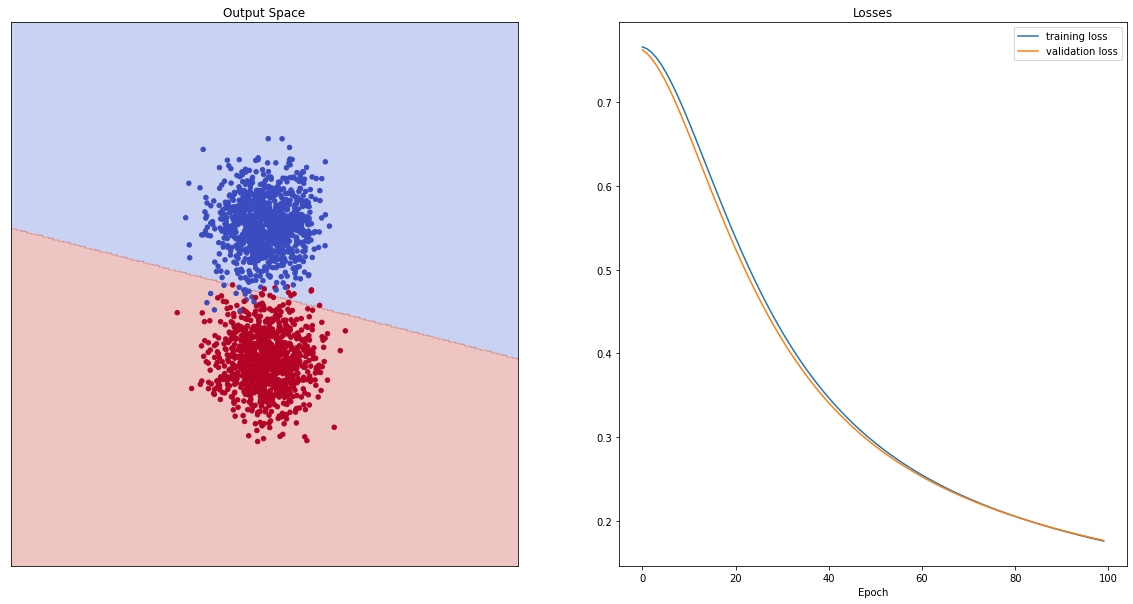

Training: [EPOCH]: 99, [LOSS]: 0.175647, [ACCURACY]: 0.994
Validation: [EPOCH]: 99, [LOSS]: 0.176460, [ACCURACY]: 0.988


In [59]:
# You can set visualize_surface to False to omit the visualization of the output space. The training will be much faster this way

losses = train(xBlobsTrain, yBlobsTrain, xBlobsVal, yBlobsVal, criterion, modelMLP, optimizer, visualize_surface=True, epochs = 100)

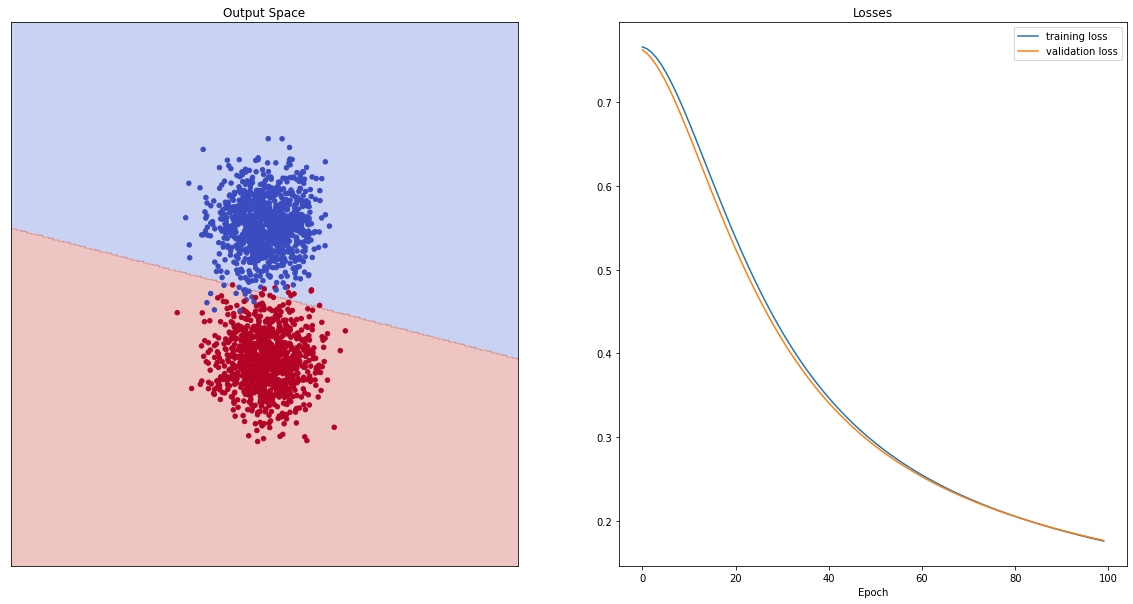

In [60]:
# Draw plots once at the end

draw_plots(xBlobsVal, yBlobsVal, modelMLP, losses, visualize_surface = True)

## Clean up

In [61]:
del xBlobsTrain, yBlobsTrain, xBlobsVal, yBlobsVal

torch.cuda.empty_cache()
torch.cuda.ipc_collect()

# Lets try with a more complex dataset

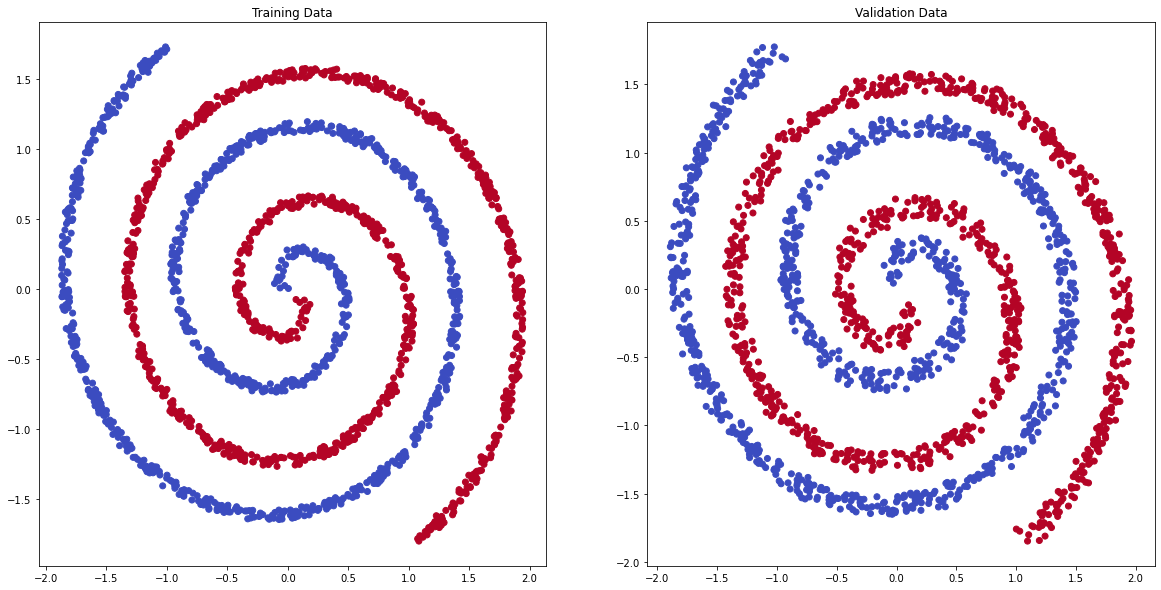

In [62]:
def make_spiral(n_points, noise=0.5):

    n = np.sqrt(np.random.rand(n_points, 1)) * 780 * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(n_points, 1) * noise
    d1y = np.sin(n)*n + np.random.rand(n_points, 1) * noise

    x, y = (np.vstack((np.hstack((d1x, d1y)), np.hstack((-d1x + 1, -d1y)))),
            np.hstack((np.zeros(n_points), np.ones(n_points))).astype("int"))

    x = (x - x.mean()) / x.std()

    return x, y

N = 1000 # number of samples
xSpiralTrain, ySpiralTrain, xSpiralVal, ySpiralVal = generate_data(N, make_spiral, noise=0.5)

#Convert the data from numpy arrays into PyTorch tensors
xSpiralTrain = torch.from_numpy(xSpiralTrain).float()
ySpiralTrain = torch.from_numpy(ySpiralTrain).long()
xSpiralVal = torch.from_numpy(xSpiralVal).float()
ySpiralVal = torch.from_numpy(ySpiralVal).long()

# move data to gpu if available
xSpiralTrain = xSpiralTrain.to(device)
ySpiralTrain = ySpiralTrain.to(device)

xSpiralVal = xSpiralVal.to(device)
ySpiralVal = ySpiralVal.to(device)

### Run Training

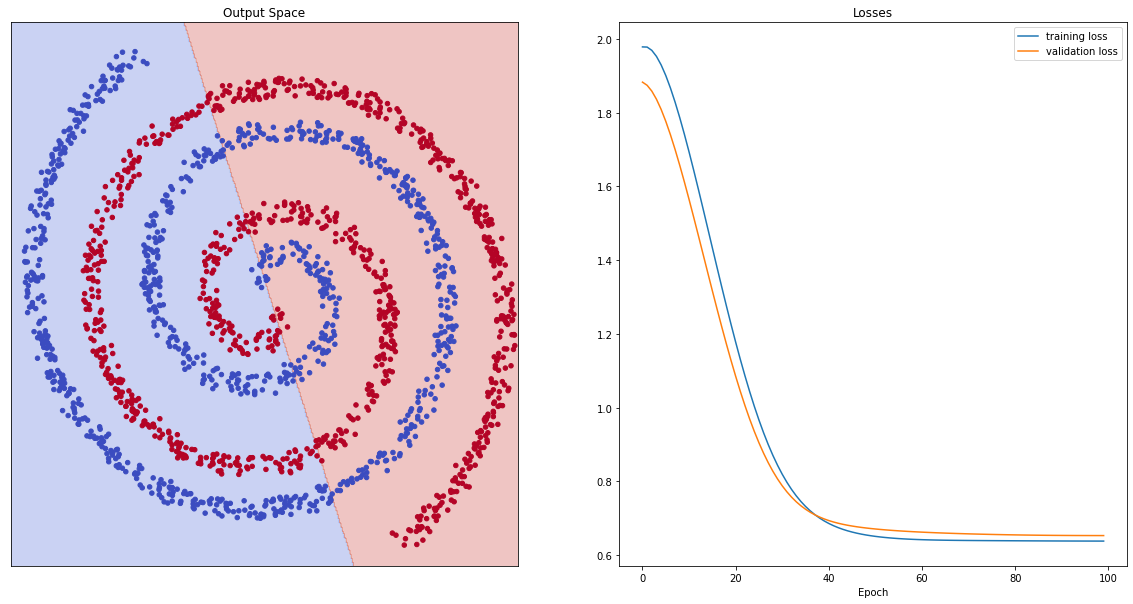

Training: [EPOCH]: 99, [LOSS]: 0.638102, [ACCURACY]: 0.620
Validation: [EPOCH]: 99, [LOSS]: 0.653056, [ACCURACY]: 0.603


In [63]:
# You can set visualize_surface to False to omit the visualization of the output space. The training will be much faster this way

losses = train(xSpiralTrain, ySpiralTrain, xSpiralVal, ySpiralVal, criterion, modelMLP, optimizer, visualize_surface=True, epochs = 100)

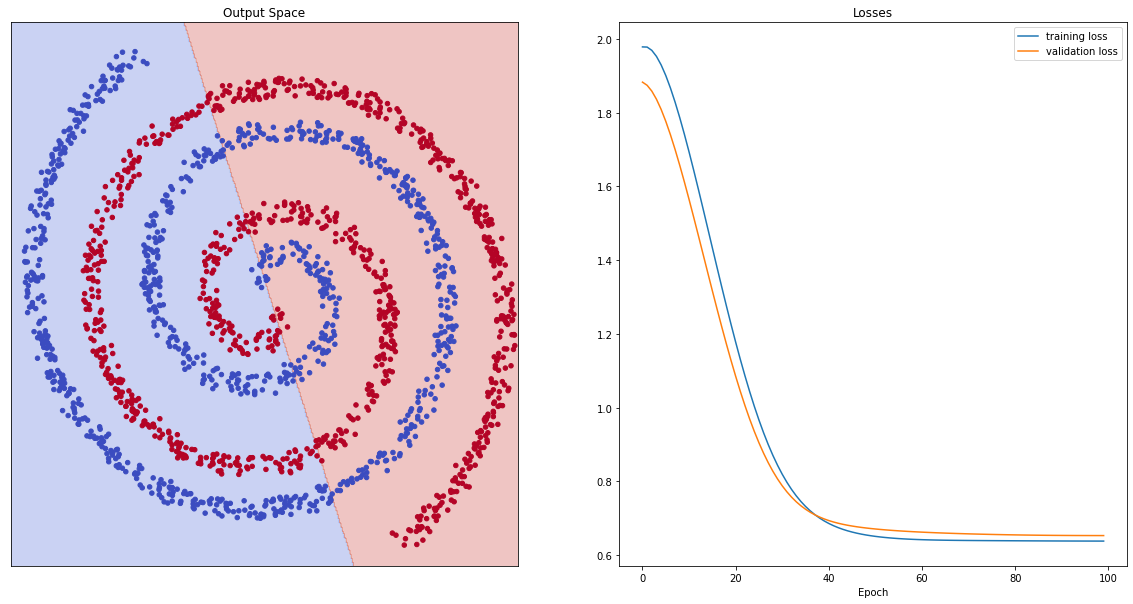

In [64]:
# Draw plots once at the end

draw_plots(xSpiralVal, ySpiralVal, modelMLP, losses, visualize_surface = True)

## Trying more complex models

As expected, the model we created is too simple to learn anything useful. It can only learn a linear decision boundary.

<font color="blue">**Exercise 3:** Can you create a model that performs well on this classification task? Change the depth of the model, the number of neurons in different layers, and the activation functions. You might also need to adjust your learning rate and/or the number of epochs.

In [65]:
# Your Code Here


In [66]:
del xSpiralTrain, ySpiralTrain, xSpiralVal, ySpiralVal

torch.cuda.empty_cache()
torch.cuda.ipc_collect()

# Regression

We can use the same procedure to tackle a regression problem. In this case, we will be producing a continuous output value, and we need to use a different loss.

The code below generates a dataset that can be used for training a regression network

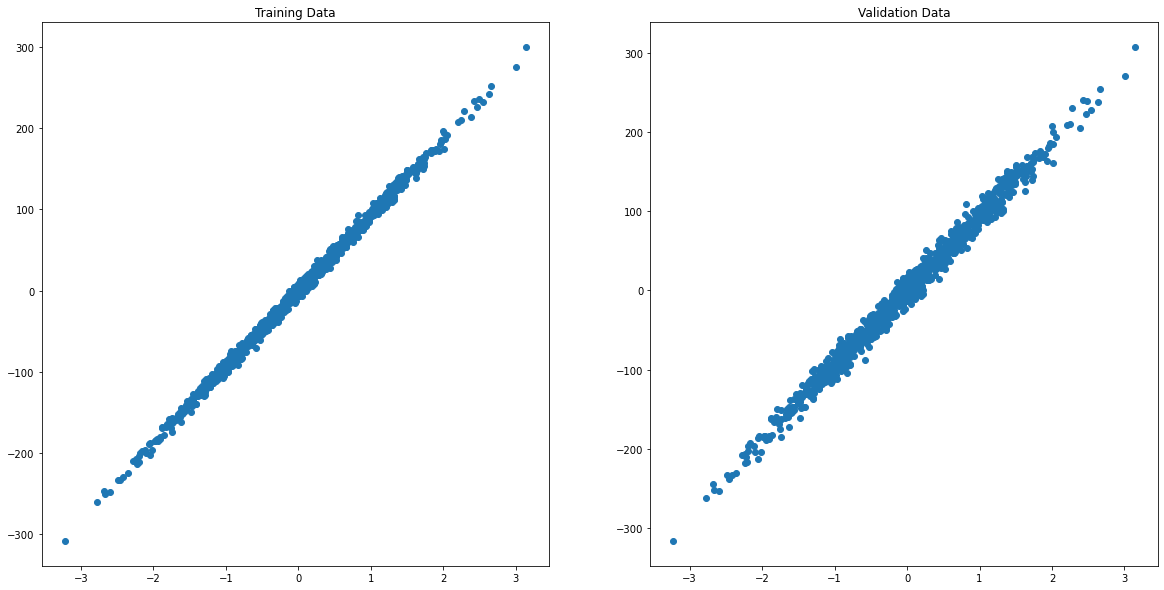

In [37]:
from sklearn.datasets import make_regression
N = 1000 # number of samples
xRegTrain, yRegTrain, xRegVal, yRegVal = generate_data(N, make_regression, regression=True, noise=5, n_features=1, random_state=52)

#Convert the data from numpy arrays into PyTorch tensors
xRegTrain = torch.from_numpy(xRegTrain).float()
yRegTrain = torch.from_numpy(yRegTrain).float()
xRegVal = torch.from_numpy(xRegVal).float()
yRegVal = torch.from_numpy(yRegVal).float()

# move data to gpu if available
xRegTrain = xRegTrain.to(device)
yRegTrain = yRegTrain.to(device)

xRegVal = xRegVal.to(device)
yRegVal = yRegVal.to(device)

<font color="blue">**Exercise 4:** Using the data generated in the cell below modify the training code to solve a regression problem.</font>


> Hints
>* Note that the generated dataset only has one feature
>* You can use the same training and validation functions with some slight modifications since it doesn't make sense to calculate accuracy in a regression problem
>* You can find different training criteria (a.k.a loss functions) in PyTorch [docs](https://pytorch.org/docs/stable/nn.html#loss-functions)


In [38]:
# Your Code Here


In [39]:
del xRegTrain, yRegTrain, xRegVal, yRegVal

torch.cuda.empty_cache()
torch.cuda.ipc_collect()

# More Classes

In the next cell we will create a dataset with more than 2 classes.

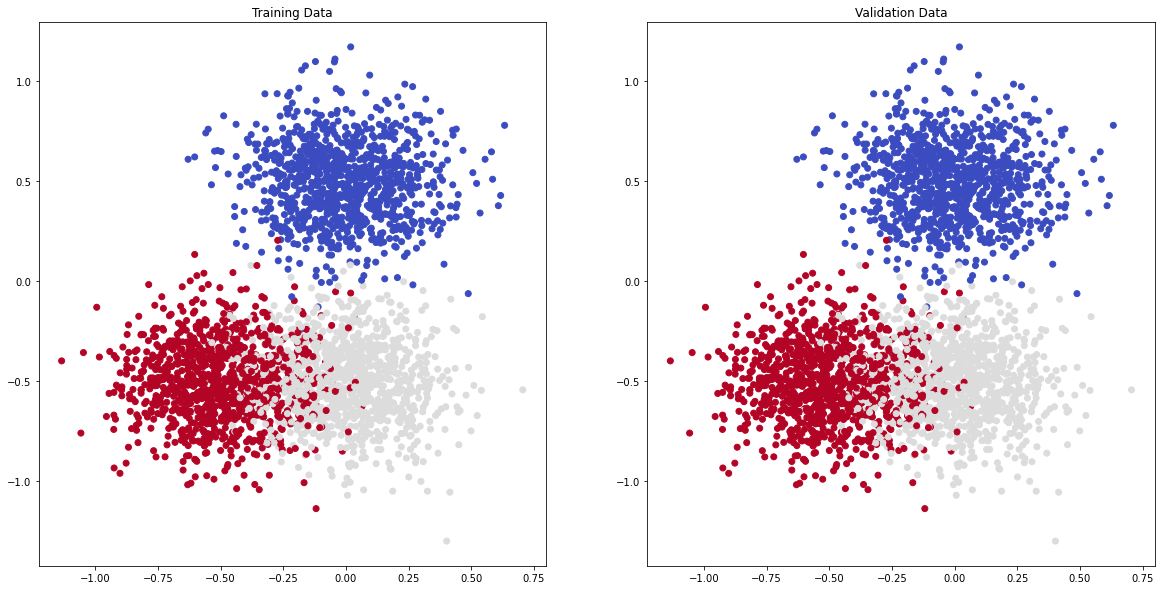

In [40]:
# find more datasets at https://scikit-learn.org/stable/modules/classes.html#samples-generator
from sklearn.datasets import make_blobs

N = 1000 # number of samples
xManyClassTrain, yManyClassTrain, xManyClassVal, yManyClassVal = generate_data([N, N, N], make_blobs, centers=[[0, 0.5], [0, -0.5], [-0.5, -0.5]], random_state=12, cluster_std=0.2)

#Convert the data from numpy arrays into PyTorch tensors
xManyClassTrain = torch.from_numpy(xManyClassTrain).float()
yManyClassTrain = torch.from_numpy(yManyClassTrain).long()
xManyClassVal = torch.from_numpy(xManyClassVal).float()
yManyClassVal = torch.from_numpy(yManyClassVal).long()

# move data to gpu if available
xManyClassTrain = xManyClassTrain.to(device)
yManyClassTrain = yManyClassTrain.to(device)

xManyClassVal = xManyClassVal.to(device)
yManyClassVal = yManyClassVal.to(device)

<font color="blue">**Exercise 5:** Using the data generated in the cell above, modify your classification model to tackle a non-binary classification problem.</font>

In [41]:
# Your Code Here


In [42]:
del xManyClassTrain, yManyClassTrain, xManyClassVal, yManyClassVal

torch.cuda.empty_cache()
torch.cuda.ipc_collect()